In [1]:
import numpy as np
import pandas as pd
from  scipy import sparse
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

In [2]:
data = np.loadtxt('stanweb.dat')

In [4]:
import time

In [5]:
# Power method without the construction of P matrix
n = data[:,0].max().astype(int)
a = 0.85
d = (1-a)/n
x = np.ones(n)/n
# x = np.random.rand(n)
z = np.zeros(n)
outter  = 0
while np.linalg.norm(x-z,2) > 10**-8:
    z = x.copy()
    x = np.zeros(n)
    buffer = []    
    t0 = time.time()
    for index,i in enumerate(data[:-1]):
        buffer.append(i)
        if index==len(data[:-1])-1:
            buffer.append(data[index+1])
        if i[0] == data[index +1][0]:
            pass
        else:
            idx = buffer[0][0].astype(int)
            if len(buffer) == 0:
                x = x + z[idx]/n
                buffer = []
            else:
                x[idx] = x[idx] + z[idx]/len(buffer)
                buffer = []
    t1 = time.time()
    x = a*x + d
    x = x/x.sum()
    outter +=1
    print(outter,np.linalg.norm(x-z,2))

1 0.0010767238240686184
2 0.001071653153526907
3 0.0009227709044026288
4 0.0006496459850423354
5 0.00039895551958139624
6 0.00022686280055245808
7 0.00012402641866912848
8 6.653146601604915e-05
9 3.538081776037068e-05
10 1.874553028172905e-05
11 9.918014281265922e-06
12 5.245609824973498e-06
13 2.7745516056460335e-06
14 1.4678278186842352e-06
15 7.766955361348746e-07
16 4.1106283397263156e-07
17 2.175857875952221e-07
18 1.1518654018072483e-07
19 6.098297171898081e-08
20 3.2287977991284e-08
21 1.7095860287810362e-08
22 9.052185937281411e-09


In [3]:
# import data
dat = pd.read_csv('stanweb.dat', sep='\t', names=['neigh', 'prob'])

In [4]:
# size of the matrix
n = dat.neigh.max()
# size of the data file
d = len(dat)
# every different index coresponds to a node 
nodes = (dat.index-1).tolist()
# links of every index 
neighbours = (dat.neigh-1).tolist()
probabilities = dat.prob.tolist()
# create a sparse matrix 
matrix = sparse.csc_matrix((probabilities,(nodes, neighbours)), shape=(d, d))
# use only the first n rows and columns that correspond to the matrix size
P = matrix[:n,:n]

In [68]:
# power method
# Inputs P: the matrix , a: teleportation parameter,toll: tollerance, max_itter : how many iterations to perfrom 
def power(P,a=0.85,toll=10**-8,max_itter=1000):
    n = P.shape[0]
#   a_ vector has zeros and ones. Ones correspond to rows of matrix P with only zeros
    a_ = np.zeros(n)
    a_[np.where(P.sum(axis=1)==0)[0]] = 1
    a_.reshape(-1,1)
    v = (np.ones(n)/n).reshape(-1,1)
    x_ = (np.ones(n)).reshape(-1,1)
    stats = []
    tmp = np.empty(n)
    for i in range(max_itter):    
#       compute the eigenvector in every itteration until the tollarance or max iteration criterio meet.
        tmp = a*P.dot(x_) + (a*a_/n).reshape(-1,1) + (1-a)*v
#     compute in every step the change of the eigenvector
        diff = np.linalg.norm(x_- tmp,2)    
        if i ==0:
#       force the first difference inf in order to not to meet tolerance criterio 
            diff = np.inf
        stats.append([i,diff])
        if diff < toll:
            break
#         x_ = tmp/ np.linalg.norm(tmp,2)
#     normalization
        x_ = tmp/tmp.sum()
    return x_,stats

In [65]:
# Gauss seidel
# Inputs P: the matrix , a: teleportation parameter,toll: tollerance, max_itter : how many iterations to perfrom 
def g_s(P,a=0.85,toll=10**-8,max_itter=1000):
    n = P.shape[0]
    I = sparse.diags(np.ones(n),offsets= 0,format='csc')
    A_ = (I-a*P)
#   construct upper and lower triangular matrices used in gauss seidel method
    L = sparse.tril(A_,k=-1,format='csc')
    U = sparse.triu(A_,k=1,format='csc')
    v = (np.ones(n)/n).reshape(-1,1)
    tmp = np.empty(n)
    x0 = (np.ones(n)).reshape(-1,1)
    x1 = (np.zeros(n)).reshape(-1,1)
    stats = []
    for i in range(max_itter):
#       compute the eigenvector in every itteration
        tmp = v-L.dot(x1.reshape(-1,1))-U.dot(x0.reshape(-1,1))
#     compute the tolerance difference
        diff =  np.linalg.norm(x1[0]-x0[0],2)
        if diff < toll:
            break
        if i==0:
            x0 = x1
        else:
            x0 = x1/x1.sum()
#       normalization
        x1 = tmp/tmp.sum()
        stats.append([i,diff])
    return x1,stats

In [73]:
# same results
gs,st = g_s(P) 
power_,st1 = power(P)
print('The difference of the methods:',np.linalg.norm(gs - power_,2))
print('Power method did:',len(st1),'iterations')
print('Gauss Seidel method did:',len(st),'iterations')

The difference of the methods: 2.2886840560269677e-05
Power method did: 40 iterations
Gauss Seidel method did: 12 iterations


### Question b

In [78]:
gs_b,st_b = g_s(P,a=0.99 ) 
power_b,st1_b = power(P,a=0.99)
print('The difference of the methods with a=0,99:',np.linalg.norm(gs_b - power_b,2))
print('Power method with a=0,99 did:',len(st1_b),'iterations')
print('Gauss Seidel method with a=0,99 did:',len(st_b),'iterations')

The difference of the methods with a=0,99: 2.5161216092306838e-05
Power method with a=0,99 did: 185 iterations
Gauss Seidel method with a=0,99 did: 12 iterations


In [159]:
top50_gs = np.linalg.norm(np.argsort(gs,axis=0)[n-50:n][:,0] - np.argsort(gs_b,axis=0)[n-50:n][:,0],2)
top50_power = np.linalg.norm(np.argsort(power_,axis=0)[n-50:n][:,0] - np.argsort(power_b,axis=0)[n-50:n][:,0] ,2)
print('The ranking of top 50 nodes in Power method changed by:',top50_power)
print('The ranking of top 50 nodes in Gauss Seidel method changed by:',top50_gs)

The ranking of top 50 nodes in Power method changed by: 948638.6101340173
The ranking of top 50 nodes in Gauss Seidel method changed by: 321152.44113971794


In [152]:
top50_gs = np.linalg.norm(gs[np.argsort(gs,axis=0)[n-50:n]][:,0,0]- gs_b[np.argsort(gs_b,axis=0)[n-50:n]][:,0,0],2)
top50_power = np.linalg.norm(power_[np.argsort(power_,axis=0)[n-50:n]][:,0,0]-power_b[np.argsort(power_b,axis=0)[n-50:n]][:,0,0] ,2)
print('The score of top 50 nodes in Power method changed by:',top50_power)
print('The score of top 50 nodes in Gauss Seidel method changed by:',top50_gs)

The score of top 50 nodes in Power method changed by: 3.129647865606001e-10
The score of top 50 nodes in Gauss Seidel method changed by: 1.3953265737258508e-07


### Question C

In [163]:
bench_power,itter = power(P)
res = []
diff_power = []
for i in range(len(itter)):
    x,_ = power(P,max_itter=i)
    res.append(np.linalg.norm(bench_power-x,2))
    diff_power.append(bench_power-x)
    
bench_gs,itter_gs = g_s(P)
res_gs = []
diff_gs = []
for i in range(len(itter_gs)):
    x,_ = g_s(P,max_itter=i)
    res_gs.append(np.linalg.norm(bench_gs-x,2))
    diff_gs.append(bench_gs-x)

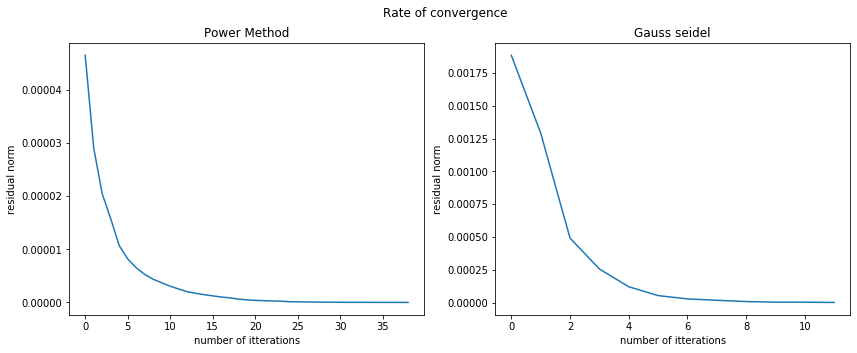

In [161]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols= 2,figsize=(14,5))
fig.suptitle('Rate of convergence ')
ax1.plot(np.arange(len(itter)-1),res[1:])
ax1.set_title('Power Method')
ax1.set_xlabel('number of itterations')
ax1.set_ylabel('residual norm')

ax2.plot(np.arange(len(itter_gs)),res_gs)
ax2.set_title('Gauss seidel')
ax2.set_xlabel('number of itterations')
ax2.set_ylabel('residual norm')
plt.show()

In [259]:
least = []
top = []
for i in range(len(diff_power)):
    least.append(np.linalg.norm(diff_power[i][np.argsort(bench_power,axis=0)[:50][:,0]],2))
    top.append(np.linalg.norm(diff_power[i][np.argsort(bench_power,axis=0)[n-50:n][:,0]],2))
    
least_gs = []
top_gs = []
for i in range(len(diff_gs)):
    least_gs.append(np.linalg.norm(diff_gs[i][np.argsort(bench_gs,axis=0)[:50][:,0]],2))
    top_gs.append(np.linalg.norm(diff_gs[i][np.argsort(bench_gs,axis=0)[n-50:n][:,0]],2))

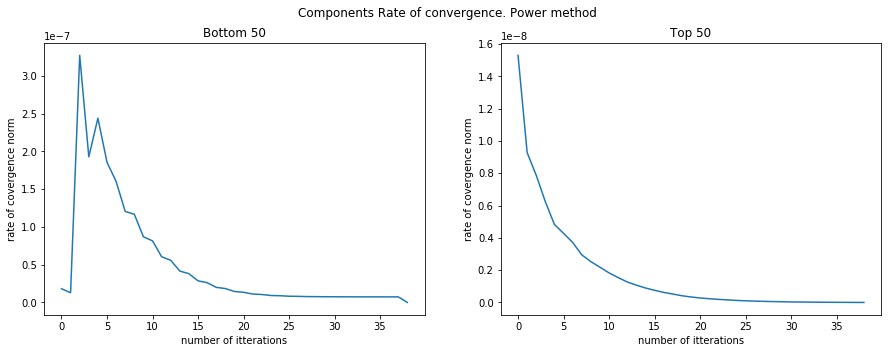

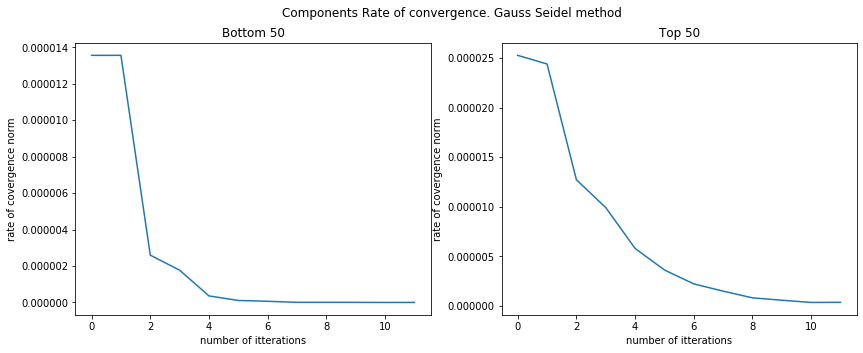

In [271]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols= 2,figsize=(15,5))
fig.suptitle('Components Rate of convergence. Power method ')
ax1.plot(np.arange(len(diff_power)-1),least[1:])
ax1.set_title('Bottom 50')
ax1.set_xlabel('number of itterations')
ax1.set_ylabel('rate of covergence norm')

ax2.plot(np.arange(len(diff_power)-1),top[1:])
ax2.set_title('Top 50')
ax2.set_xlabel('number of itterations')
ax2.set_ylabel('rate of covergence norm')
plt.show()

fig, (ax1, ax2) = plt.subplots(nrows=1,ncols= 2,figsize=(14,5))
fig.suptitle('Components Rate of convergence. Gauss Seidel method ')
ax1.plot(np.arange(len(diff_gs)),least_gs)
ax1.set_title('Bottom 50')
ax1.set_xlabel('number of itterations')
ax1.set_ylabel('rate of covergence norm')

ax2.plot(np.arange(len(diff_gs)),top_gs)
ax2.set_title('Top 50')
ax2.set_xlabel('number of itterations')
ax2.set_ylabel('rate of covergence norm')
plt.show()